## 0. Notebook description

This notebook represents our baseline. It uses five convolutional layers and achieves an accuracy of 0.60. In the following notebooks we try to improve this accuracy even further by changing the CNN model or increasing the number of input images (augmentation, GAN).

## 1. Importing libraries and loading the data

In [1]:
# Import Libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report
from utils.preprocessing import load_data, ReshapeAndScale, create_dataloaders
from utils.fer2013_dataset import Fer2013Dataset

First, we load the data into a pandas dataframe.

In [7]:
train_df = load_data("data/oversampled_train.csv")
val_df = load_data("data/validation.csv")

print("Training Data")
print(train_df.head(10))

print("\n\nValidation Data")
print(val_df.head(10))

Training Data
                                              pixels  emotion
0  252 253 252 252 251 243 237 209 209 212 226 19...        6
1  94 91 77 66 56 53 51 45 47 49 40 42 43 46 42 4...        0
2  91 82 65 66 75 89 108 119 124 134 139 139 134 ...        3
3  139 101 115 141 191 245 240 235 243 239 234 23...        1
4  238 237 238 239 238 238 237 248 183 189 136 53...        1
5  140 127 126 152 149 142 143 129 101 107 146 14...        5
6  181 246 193 129 133 221 220 213 139 84 67 30 2...        6
7  7 8 8 8 16 28 38 41 40 38 37 37 37 39 40 42 43...        2
8  196 198 177 156 103 44 37 37 57 80 89 85 82 81...        0
9  0 0 0 0 0 0 0 0 2 0 7 46 54 61 56 25 23 29 30 ...        4


Validation Data
   emotion                                             pixels
0        3  254 253 253 254 254 254 252 252 253 252 253 25...
1        4  92 70 64 65 62 64 91 139 167 181 186 187 191 1...
2        5  20 19 16 23 24 25 34 24 25 60 113 123 139 149 ...
3        4  79 82 83 84 85 89 92 90 93

In [8]:
print("Training data shape:", train_df.shape)
print("Validation data shape", val_df.shape)

Training data shape: (40404, 2)
Validation data shape (5742, 2)


## 2. Define a custom dataset

We define a custom PyTorch dataset class, `Fer2013Dataset`, for handling the FER2013 data. The dataset is designed to load images (stored as pixel strings) and their corresponding emotion labels. It also supports optional transformations to preprocess the images during training. This setup makes it easy to integrate the dataset with PyTorch DataLoaders.

The class is contained in the `utils/fer2013_dataset` file

We also apply the following preprocessing steps to convert the data into the desired format we can further work with:
1. **Reshaping**:
   - Convert the pixel string into a `48x48` matrix for visualization and processing.
2. **Scaling**:
   - Scale pixel values to the range `[0, 1]` by dividing the pixel values by 255.
3. **Normalization**:
   - Normalize pixel values to the range `[-1, 1]` by subtracting the mean and diving them by the standard deviation.


These preprocessing steps are contained in the class `ReshapeAndScale`, which is available under path `utils/preprocessing.py`.

In [9]:
# Define a default transformation pipeline
transform = transforms.Compose([
    ReshapeAndScale(n_rows=48, n_cols=48),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

In [10]:
train_dataset = Fer2013Dataset(train_df, train_df['emotion'], transform=transform)
val_dataset = Fer2013Dataset(val_df, val_df['emotion'], transform=transform)

### Create DataLoaders

We create DataLoaders for both subsets to enable batch processing. The training DataLoader shuffles the data for better learning, while the validation DataLoader does not. Finally, we print the shapes of the batches to verify that everything works correctly.


In [11]:
batch_size = 32
train_loader, val_loader = create_dataloaders(train_dataset, val_dataset, batch_size)

## 3. Define the CNN model

We define a custom Convolutional Neural Network (CNN) for emotion recognition. The model includes multiple convolutional layers with batch normalization, dropout for regularization, max pooling for downsampling, and fully connected layers for classification. 

The network dynamically calculates the flattened size needed for the fully connected layers based on the input size (48x48 grayscale images). Finally, we instantiate the model, move it to the available device (CPU or GPU), and print its architecture for verification.


In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # 1st Conv Layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding='valid')
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.25)

        # 2nd Conv Layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 3rd Conv Layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='valid')
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout(0.25)

        # 4th Conv Layer
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 5th Conv Layer
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='valid')
        self.bn5 = nn.BatchNorm2d(128)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the flatten size dynamically
        self.flatten_size = self._get_flatten_size()

        # Fully Connected Layers
        self.fc1 = nn.Linear(self.flatten_size, 250)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(250, 7)  # 7 classes for emotion recognition

    def _get_flatten_size(self):
        # Create a dummy tensor with the same size as input image
        dummy_input = torch.zeros(1, 1, 48, 48)  # batch_size, channels, height, width
        dummy_output = self._forward_conv_layers(dummy_input)
        return dummy_output.numel()

    def _forward_conv_layers(self, x):
        # Pass through convolutional layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool4(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.pool5(x)

        return x

    def forward(self, x):
        # Use the convolutional layers defined in _forward_conv_layers
        x = self._forward_conv_layers(x)

        # Dynamically flatten the output
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)

        return x

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN()
model = model.to(device)

# Print model to verify layers
print(model)    

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=val

## 4. Define Loss Function and Optimizer

In this cell, we define the loss function and optimizer for training the model:
- **Loss Function**: `CrossEntropyLoss` is used, which is well-suited for multi-class classification tasks like emotion recognition.
- **Optimizer**: The Adam optimizer is initialized with a learning rate of `0.0001` to update the model parameters during training.

In [8]:
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # call optimizer

## 5. Train the Model

In this cell, we define the training loop for the CNN:
- **Number of Epochs**: The model is trained for 35 epochs.
- **Training Process**:
  - The model is set to training mode.
  - For each batch, we move inputs and labels to the appropriate device, clear the gradients, perform forward and backward passes, and update the model's parameters using the optimizer.
  - The running loss is tracked and printed every 100 batches for monitoring.

In [30]:
# Initialize TensorBoard writer
writer = SummaryWriter(log_dir='tensorboard-runs/1_Group17_DLProject')

checkpoint_path = 'model-checkpoints/1_Group17_DLProject'
os.makedirs(checkpoint_path, exist_ok=True)

model_save_path = 'models'
os.makedirs(model_save_path, exist_ok=True)

num_epochs = 35
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 100 == 0:  # Print every 100 batches
            avg_loss = running_loss / 100
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {avg_loss:.4f}")
            running_loss = 0.0

            # Log loss to TensorBoard
            writer.add_scalar('Loss/train', avg_loss, epoch)

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss,
        }
        torch.save(checkpoint, f"{checkpoint_path}/checkpoint_epoch_{epoch + 1}.pth")
        print(f"Checkpoint saved at epoch {epoch + 1}")

# Save the final model after training
final_model_path = os.path.join(model_save_path, '1_Group17_DLProject.pth')
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved at {final_model_path}")

# Close the writer after training
writer.close()

Epoch [1/35], Step [100/1263], Loss: 1.9270
Epoch [1/35], Step [200/1263], Loss: 1.8569
Epoch [1/35], Step [300/1263], Loss: 1.8277
Epoch [1/35], Step [400/1263], Loss: 1.7800
Epoch [1/35], Step [500/1263], Loss: 1.7490
Epoch [1/35], Step [600/1263], Loss: 1.7068
Epoch [1/35], Step [700/1263], Loss: 1.6631
Epoch [1/35], Step [800/1263], Loss: 1.6380
Epoch [1/35], Step [900/1263], Loss: 1.5942
Epoch [1/35], Step [1000/1263], Loss: 1.5751
Epoch [1/35], Step [1100/1263], Loss: 1.5435
Epoch [1/35], Step [1200/1263], Loss: 1.5046
Epoch [2/35], Step [100/1263], Loss: 1.4759
Epoch [2/35], Step [200/1263], Loss: 1.4495
Epoch [2/35], Step [300/1263], Loss: 1.4318
Epoch [2/35], Step [400/1263], Loss: 1.4173
Epoch [2/35], Step [500/1263], Loss: 1.3895
Epoch [2/35], Step [600/1263], Loss: 1.3895
Epoch [2/35], Step [700/1263], Loss: 1.3705
Epoch [2/35], Step [800/1263], Loss: 1.3533
Epoch [2/35], Step [900/1263], Loss: 1.3523
Epoch [2/35], Step [1000/1263], Loss: 1.3420
Epoch [2/35], Step [1100/126

## 6. Evaluate the Model

In this cell, we evaluate the trained model using the validation dataset:
- The model is set to evaluation mode, and gradient computation is disabled.
- For each batch, we perform a forward pass and predict the class labels.
- Ground truth labels and predictions are stored and used to generate a classification report using `sklearn`. This report provides precision, recall, and F1-scores for each emotion class.

              precision    recall  f1-score   support

       Angry       0.57      0.45      0.50       799
     Disgust       0.68      0.59      0.63        87
        Fear       0.45      0.47      0.46       820
       Happy       0.79      0.83      0.81      1443
         Sad       0.46      0.49      0.48       966
    Surprise       0.70      0.74      0.72       634
     Neutral       0.54      0.52      0.53       993

    accuracy                           0.60      5742
   macro avg       0.60      0.58      0.59      5742
weighted avg       0.60      0.60      0.60      5742



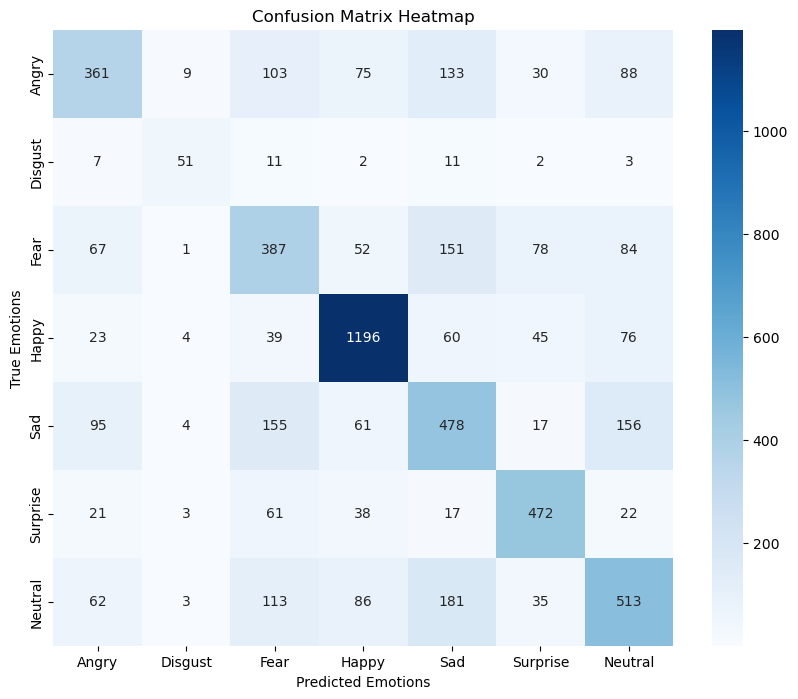

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

model = CNN()
model = model.to(device)
model_path = 'models/1_Group17_DLProject.pth'
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()

# Initialize lists to store ground truth and predictions
y_true, y_pred = [], []

# Disable gradient computation
with torch.no_grad():
    for inputs, labels in val_loader:
        # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get the predicted class
        _, predicted = torch.max(outputs, 1)

        # Append ground truth and predictions to respective lists
        y_true.extend(labels.cpu().numpy())  # Convert tensors to numpy
        y_pred.extend(predicted.cpu().numpy())

# Generate the classification report
emotion_labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_names=list(emotion_labels.values())
print(classification_report(y_true, y_pred, target_names=emotion_names))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Create a heatmap visualization
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_names, yticklabels=emotion_names)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Emotions")
plt.ylabel("True Emotions")
plt.show()



### Conclusion
As we have a balanced dataset, we measure performance based on accuracy. The report above shows that our baseline achieves an accuracy of 0.60, which we will try to improve in the next notebooks. 
The model appears best at classifying the emotion "Happy", likely because this label has the most number of examples, but potentially because of the recognizable pixel pattern in images with this emotion classification (a cresecent of white pixels near the center of the image, representing a smile). 

The model also performs well at classifying "surprise" images, likely because most of these images show a person with an open "O"-shaped mouth, which provides the model with a predictable pixel pattern. 
The model performs relatively poorly at classifying images of disgust, likely because there are so few training examples of this label compared to the other emotion labels.

Images with the "angry" label are frequently misclassified as "sad" and "fear". It is possible that these misclassifications happen because of the shared pixel pattern of a downturned mouth with "angry", "sad", and "fear" images.